In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0,0]).float()
o2 = torch.tensor([10,0]).float()
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [o2, o1]
target = mm.multipleCircles(origin_target, [r2, r1], nb_pts)

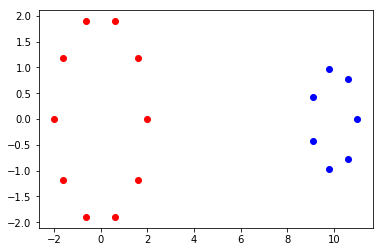

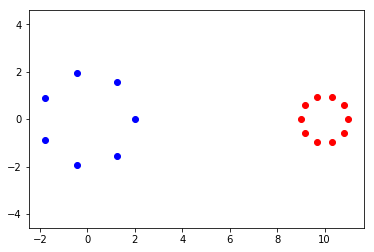

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 10
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

sigma2 = 10
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

sigma_bg = 0.1

In [5]:
# defining cotangent variable
# needed to prevent that everything is symmetric (gradient would be zero and nothing moves)
modules.manifold.fill_cotan( [*[torch.rand(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.rand(gd.shape) for gd in modules.manifold.gd[-1]]])

In [6]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
gd0_list = [*source, source]
mom0_list = [*[torch.rand(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.rand(gd.shape) for gd in modules.manifold.gd[-1]]]

In [8]:
# set parameters
reg_param = 10**-2 # regularisation parameter

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_()
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)
gradE = torch.autograd.grad(EnergyFunctional.energy_tensor(gd0_tensor, mom0_tensor), mom0_tensor, create_graph=True, allow_unused=True)
    
# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional.energy_tensor, EnergyFunctional.gradE, X)

RuntimeError: Lapack Error in gesv : U(2,2) is zero, singular U. at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THTensorLapack.cpp:155

In [ ]:
EnergyFunctional.attach(gd0_list, target)

In [116]:
EnergyFunctional.cost(gd0_list, modules.controls)

tensor(0., grad_fn=<AddBackward0>)

In [119]:
#EnergyFunctional.shoot(gd0_list, mom0_list)

In [142]:
#EnergyFunctional.energy_tensor(gd0_tensor, mom0_tensor)

gd1 shape torch.Size([20]) torch.Size([14]) torch.Size([20]) torch.Size([14])


tensor(26.6323, grad_fn=<AddBackward0>)